# Stock Market Prediction Using Neumerical & Textual Analysis : GRIP- The Sparks Foundation

### <span style='color:lightgreen'>  Author : Irfan Pathan  </span>

### Stock analysis is the evaluation of a particular trading instrument, an investment sector, or the market as a whole. Stock analysts attempt to determine the future activity of an instrument, sector, or market.

**Stock analysis is the practice of using information and analyzing data to make investment decisions.**

### Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

### Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

### Downlaod Historical Stock Prices - "https://finance.yahoo.com/"

### Downlaod Textual(News) Data- "https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH"

**Using historical stock price data, I applied the Auto-ARIMA model to anticipate stock market values. To make the predictions in the sentiment analysis model, I used a variety of machine learning techniques, including Random Forest Regressor, LightGBM, Adaboost, and Xgboost.**

So, Lets Statt the Importing Libraries

In [1]:
#!pip install yfinance --upgrade --no-cache-dir

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/irfanp056/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/irfanp056/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
import yfinance as yf
BSE_df = yf.download('^BSESN', start='2001-01-01', end='2022-03-31')

[*********************100%%**********************]  1 of 1 completed


In [4]:
BSE_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [5]:
BSE_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300
2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100
2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300


In [6]:
Indian_News_df = pd.read_csv("india-news-headlines.csv")

In [7]:
Indian_News_df.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [8]:
BSE_df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume': 'volume'}, inplace = True)

In [9]:
BSE_df.columns


Index(['open', 'high', 'low', 'close', 'adjclose', 'volume'], dtype='object')

In [10]:
BSE_df.reset_index(inplace=True)


In [11]:
BSE_df.head()

,Date,open,high,low,close,adjclose,volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [12]:
BSE_df['Date'] = pd.to_datetime(BSE_df['Date'], format = '%Y%m%d')


In [13]:
BSE_df.isnull().sum()

Date        0
open        0
high        0
low         0
close       0
adjclose    0
volume      0
dtype: int64

Text(0, 0.5, 'Close')

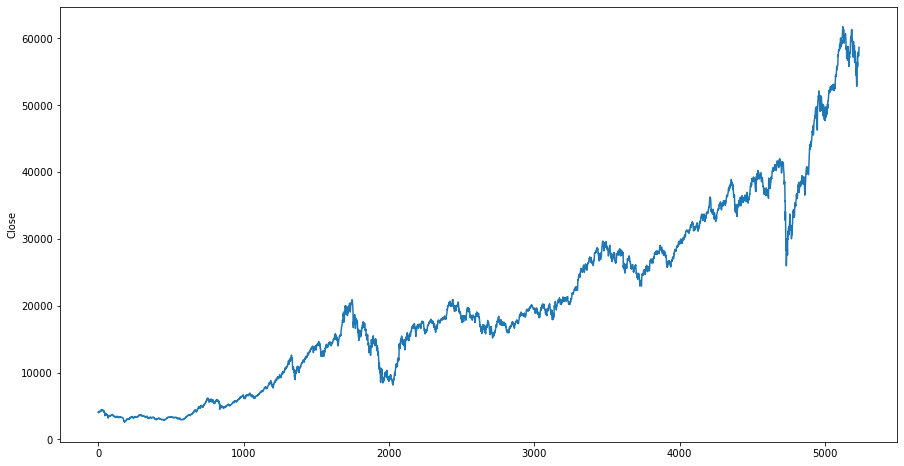

In [14]:
plt.figure(figsize=(15, 8))
BSE_df['close'].plot()
plt.ylabel('Close')

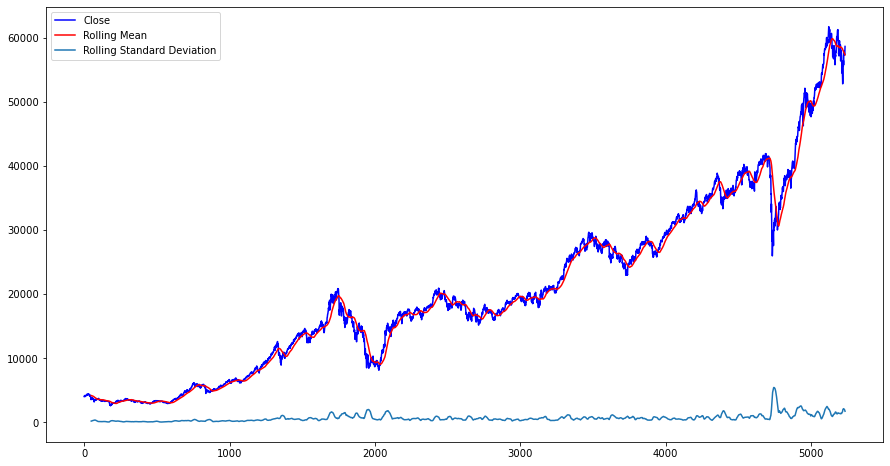

In [15]:
close = BSE_df['close']
MA = close.rolling(window = 50).mean()
STD = close.rolling(window = 50).std()

plt.figure(figsize=(15, 8))
BSE_df['close'].plot(color = 'b', label = 'Close')
MA.plot(color = 'r', label = 'Rolling Mean')
STD.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

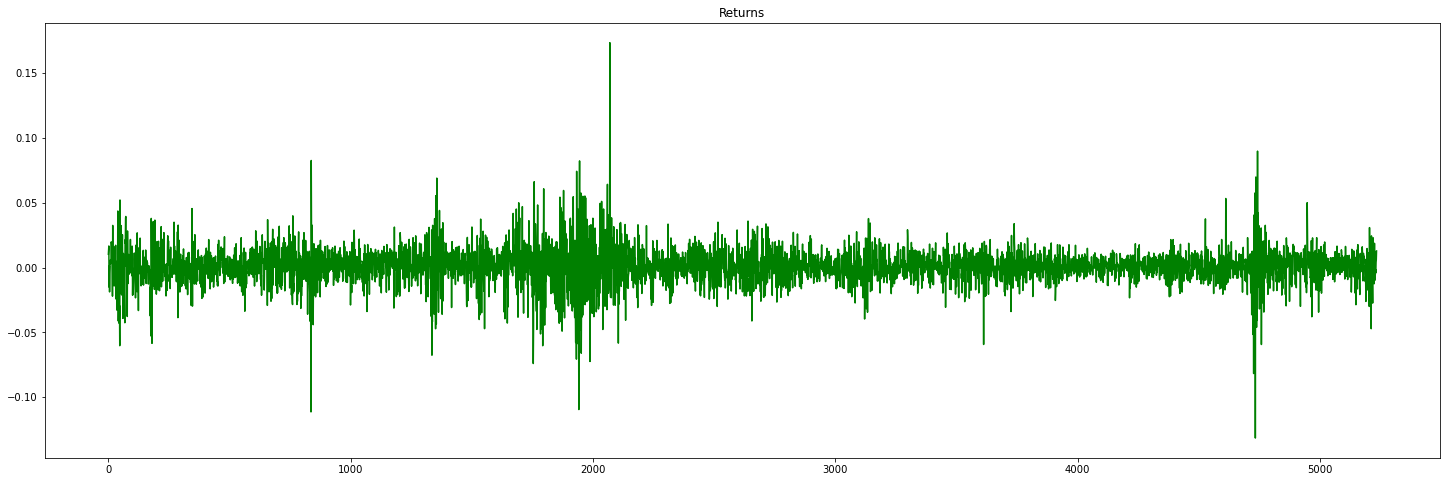

In [16]:
#Plotting returns
Returns = close / close.shift(1) - 1

plt.figure(figsize = (25,8))
Returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [17]:
Train = BSE_df[:4000]
Test = BSE_df[4000:]

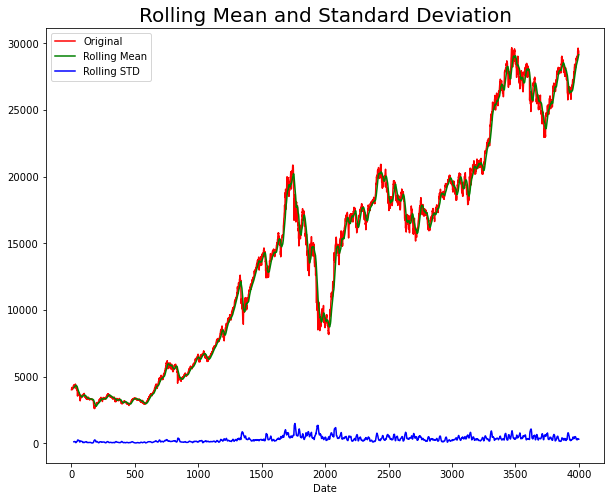

Results of Dickey Fuller Test
ADF Test Statistic : -0.23082726465554054
p-value : 0.9347459394256756
Lags Used : 5
Number of Observations Used : 3994
Weak evidence against null hypothesis, time series is non-stationary 


In [18]:
#Stationarity Series
def test_stationarity(timeseries):
 
 #Determing Rolling Stats
 RollMean = timeseries.rolling(20).mean()
 RollSTD = timeseries.rolling(20).std()

 #Plot Rolling Stats:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'r', label = 'Original')
 plt.plot(RollMean, color = 'g', label = 'Rolling Mean')
 plt.plot(RollSTD, color = 'b', label = 'Rolling STD')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of Dickey Fuller Test')
 Result = adfuller(timeseries, autolag = 'AIC')
 Labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']

 for value,label in zip(Result, Labels):
   print(label+' : '+str(value) )
 if Result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(Train['close'])

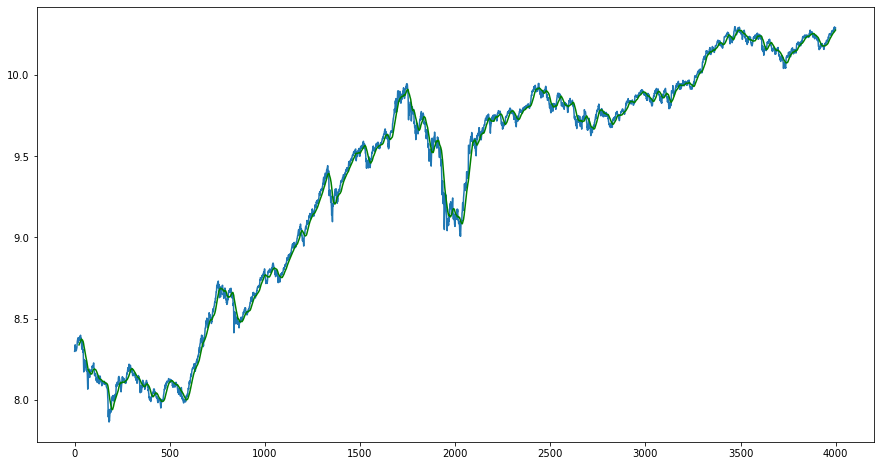

In [19]:
Train_log = np.log(Train['close']) 
Test_log = np.log(Test['close'])

MAV = Train_log.rolling(24).mean() 
plt.figure(figsize = (15,8))
plt.plot(Train_log) 
plt.plot(MAV, color = 'green') 

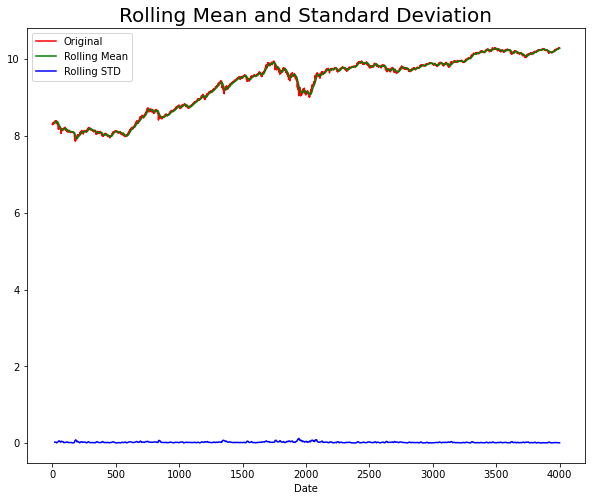

Results of Dickey Fuller Test
ADF Test Statistic : -0.8391845066632457
p-value : 0.8073401494171021
Lags Used : 2
Number of Observations Used : 3997
Weak evidence against null hypothesis, time series is non-stationary 


In [20]:
Train_log.dropna(inplace = True)
Test_log.dropna(inplace = True)

test_stationarity(Train_log)

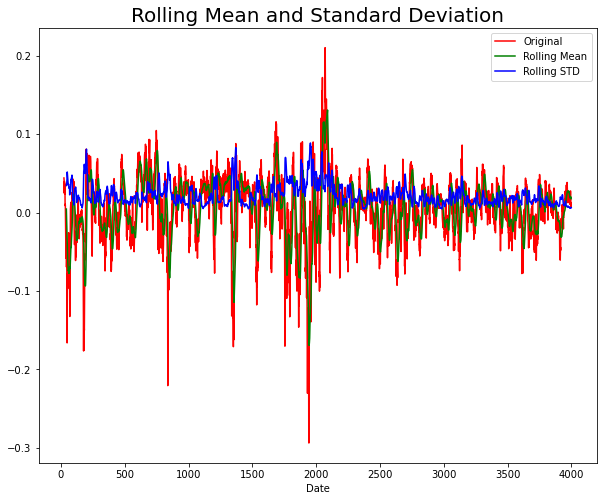

Results of Dickey Fuller Test
ADF Test Statistic : -9.214283533280923
p-value : 1.851811803709256e-15
Lags Used : 22
Number of Observations Used : 3954
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [21]:
Train_log_Diff = Train_log - MAV
Train_log_Diff.dropna(inplace = True)

test_stationarity(Train_log_Diff)

In [22]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima as AR
Model = AR(Train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
Model.fit(Train_log)
Pred = Model.predict(n_periods = len(Test))
Pred = pd.DataFrame(Pred,index = Test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-22428.642, Time=3.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22395.107, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22419.651, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22422.749, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22392.527, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22430.682, Time=1.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-22430.360, Time=1.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22426.624, Time=1.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-22428.724, Time=4.79 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-22430.775, Time=2.60 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-22428.778, Time=2.21 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-22426.809, Time=3.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-22428.252, Time=1.14 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 23.410 sec

Text(0, 0.5, 'Actual Stock Price')

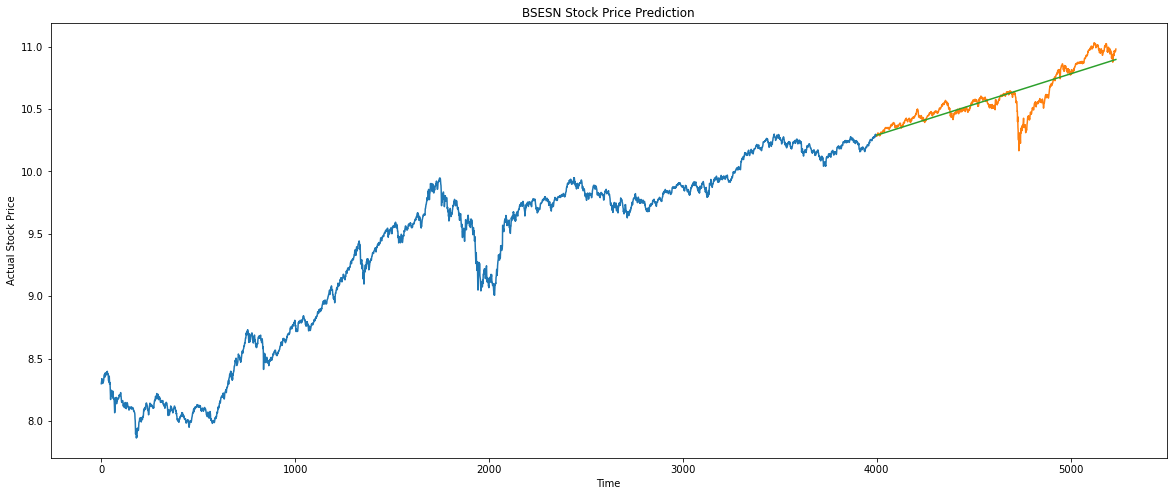

In [23]:
plt.figure(figsize = (20,8))
plt.plot(Train_log, label='Train')
plt.plot(Test_log, label='Test')
plt.plot(Pred, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [24]:
#Calculating Error
RMS = np.sqrt(mean_squared_error(Test_log,Pred))
print("RMSE : ", RMS)

RMSE :  0.10229140720679583


# TEXTUAL ANALYSIS

In [25]:
News = pd.read_csv("india-news-headlines.csv")

In [26]:
News.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [27]:
News['publish_date'] = pd.to_datetime(News['publish_date'], format = '%Y%m%d')


In [28]:
News.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [29]:
News['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [30]:
News['headline_category'].value_counts()

india                                                    297491
unknown                                                  209583
city.mumbai                                              150451
city.delhi                                               137648
business.india-business                                  121195
                                                          ...  
nepal-india-earthquake.opinion                                8
elections.lok-sabha-elections-2019.tripura.news               8
best-products.home-decor-and-garden.living-room-decor         8
profiles.india-profiles                                       8
pms-us-visit                                                  8
Name: headline_category, Length: 1041, dtype: int64

In [31]:
News['headline_category'].value_counts().count()

1041

In [32]:
News['headline_text'].value_counts()

Straight Answers                                                                                                          6723
Cartoons                                                                                                                  1536
Straight answers                                                                                                          1500
Photogallery                                                                                                              1353
Your say                                                                                                                  1012
                                                                                                                          ... 
Pak President Asif Ali Zardari at 7RCR; meets Manmohan Singh                                                                 1
Why Goa Inc is so happy with CM Manohar Parrikar                                                               

In [33]:
News['headline_text'].value_counts().count()


3387380

In [34]:
News.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [35]:
#determining whether any duplicate values exist

News.duplicated().sum()

24860

In [36]:
#simple verification by declaring all duplicates as True. First is the default setting, which flags duplicates as False everywhere but the first instance.
News.duplicated(keep=False).sum()

47452

In [37]:
Cols = list(News.columns)

News.sort_values(by=Cols, inplace=True, ignore_index=True)

In [38]:
News[News.duplicated(keep=False)]

,publish_date,headline_category,headline_text
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,America's unwanted heading for India?
5,2001-01-02,unknown,America's unwanted heading for India?
6,2001-01-02,unknown,America's unwanted heading for India?
9,2001-01-02,unknown,BBC's reality TV will focus on AIIMS
...,...,...,...
3646165,2022-03-22,city.hubballi,BJP divided over probable induction of Basavar...
3648600,2022-03-27,city.chennai,Father; daughter killed in TN as e-bike on cha...
3648601,2022-03-27,city.chennai,Father; daughter killed in TN as e-bike on cha...
3649664,2022-03-29,city.hyderabad,Telangana logs 30 new Covid cases


In [39]:
#removing duplicates only maintaining the final value of each duplicate (often the last row from the sorted order)

News.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [40]:
News.duplicated().sum()


0

### Use of TextBlob to 

In [41]:
#getting a list of unique dates in publish_date column

New_List = News['publish_date'].value_counts().index.tolist()

In [42]:
#combining all headline_text column values that correspond to the same date in the publish_date column
data = []
for x in New_List:
  df = News.loc[News['publish_date'] == x]
  headlinetext = ''
  publishdate = str(x)
  headlinetext = df['headline_text'].iloc[0]
  for i in range(1 , len(df)):
    headlinetext = headlinetext + '. '+ str(df['headline_text'].iloc[i])  
  data.append(headlinetext)

In [43]:
# Create a New Dataframe
News_df = pd.DataFrame({'publish_date': New_List, 'headline_text' : data})

In [44]:
News_df.head()

,publish_date,headline_text
0,2014-12-15,Golden Homes III. Golden Panorama. Hanging Gar...
1,2014-12-21,Eight companies add Rs 55;171 crore in m-cap; ...
2,2014-12-09,Audi-Vredestein driving experience. Benelli TN...
3,2014-11-29,6 CARE IPO merchant bankers fined Rs 1 crore. ...
4,2014-12-27,New generation Audi Q7 being tested in India. ...


In [45]:
# Sort the dataframe based on dates
News_df.sort_values(by='publish_date', inplace=True, ignore_index=True)

In [46]:
News_df.head()

,publish_date,headline_text
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...
4,2001-01-06,Anti-immigration think-tank berates Clinton re...


In [47]:
News_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7717 entries, 0 to 7716
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   publish_date   7717 non-null   datetime64[ns]
 1   headline_text  7717 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 120.7+ KB


In [48]:
polarity = []
subjectivity = []
for idx, row in News_df.iterrows():
  polarity.append(TextBlob(row['headline_text']).sentiment[0])
  subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

In [49]:
News_df['polarity'] = polarity
News_df['subjectivity'] = subjectivity

In [50]:
News_df.head()

,publish_date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [51]:
News_df.isnull().sum()

publish_date     0
headline_text    0
polarity         0
subjectivity     0
dtype: int64

In [52]:
News_df.head()

,publish_date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [53]:
#renameing the publish_date to date so it will help us during joining this dataset with bse_data dataset
News_df.rename(columns={'publish_date': 'Date'}, inplace = True)

In [54]:
News_df.head()

,Date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [55]:
#selecting required columns
#News_df = News_df.filter(['Date', 'polarity', 'subjectivity'], axis=1)

In [56]:
News_df['Date'].duplicated().sum()

0

In [57]:
News_df.head()

,Date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [58]:
News_df.shape

(7717, 4)

In [59]:
BSE_df.shape

(5234, 7)

In [60]:
BSE_df['Date'].duplicated().sum()

0

In [61]:
# Add Sentiment Score to News_df
SIA = SentimentIntensityAnalyzer()

News_df['Compound'] = [SIA.polarity_scores(v)['compound'] for v in News_df['headline_text']]
News_df['Negative'] = [SIA.polarity_scores(v)['neg'] for v in News_df['headline_text']]
News_df['Neutral'] = [SIA.polarity_scores(v)['neu'] for v in News_df['headline_text']]
News_df['Positive'] = [SIA.polarity_scores(v)['pos'] for v in News_df['headline_text']]
News_df

,Date,headline_text,polarity,subjectivity,Compound,Negative,Neutral,Positive
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056,-0.9145,0.132,0.779,0.089
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692,-0.2640,0.122,0.766,0.111
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895,0.8548,0.096,0.802,0.102
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542,0.4935,0.145,0.691,0.164
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935,-0.5574,0.165,0.702,0.133
...,...,...,...,...,...,...,...,...
7712,2022-03-27,F1 2022: Sergio Perez grabs pole position at S...,0.026188,0.371042,-0.9999,0.130,0.802,0.069
7713,2022-03-28,Adani Total forays into electric mobility infr...,0.055232,0.389939,-0.9998,0.145,0.758,0.097
7714,2022-03-29,'ONGC sells Russia's Sokol oil to Indian refin...,0.095037,0.404044,-0.9999,0.139,0.782,0.079
7715,2022-03-30,8 days; 7 hikes: Petrol crosses Rs 100/L mark....,0.037729,0.350965,-0.9998,0.124,0.812,0.065


In [62]:
BSE_df = pd.merge(BSE_df, News_df, how='left', on=['Date'])

In [63]:
BSE_df.head()

,Date,open,high,low,close,adjclose,volume,headline_text,polarity,subjectivity,Compound,Negative,Neutral,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056,-0.9145,0.132,0.779,0.089
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692,-0.2640,0.122,0.766,0.111
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895,0.8548,0.096,0.802,0.102
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542,0.4935,0.145,0.691,0.164
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0,42 units to be sealed in phase-II of operation...,0.016234,0.436176,-0.8934,0.118,0.802,0.080


In [64]:
BSE_df.tail()

,Date,open,high,low,close,adjclose,volume,headline_text,polarity,subjectivity,Compound,Negative,Neutral,Positive
5229,2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400,Exicom completes installation of 5;000 EV char...,0.042891,0.364423,-0.9999,0.157,0.767,0.076
5230,2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900,Okinawa expects to sell 50;000 units of newly-...,-0.011677,0.373186,-1.0000,0.166,0.769,0.065
5231,2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300,Adani Total forays into electric mobility infr...,0.055232,0.389939,-0.9998,0.145,0.758,0.097
5232,2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100,'ONGC sells Russia's Sokol oil to Indian refin...,0.095037,0.404044,-0.9999,0.139,0.782,0.079
5233,2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300,8 days; 7 hikes: Petrol crosses Rs 100/L mark....,0.037729,0.350965,-0.9998,0.124,0.812,0.065


In [65]:
BSE_df.isnull().sum().sum()

203

In [66]:
New_df = BSE_df[['close','subjectivity', 'polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
New_df

,close,subjectivity,polarity,Compound,Negative,Neutral,Positive
0,4018.879883,0.293056,0.193519,-0.9145,0.132,0.779,0.089
1,4060.020020,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,4115.370117,0.481895,0.091426,0.8548,0.096,0.802,0.102
3,4183.729980,0.465542,0.257415,0.4935,0.145,0.691,0.164
4,4120.430176,0.436176,0.016234,-0.8934,0.118,0.802,0.080
...,...,...,...,...,...,...,...
5229,57595.679688,0.364423,0.042891,-0.9999,0.157,0.767,0.076
5230,57362.199219,0.373186,-0.011677,-1.0000,0.166,0.769,0.065
5231,57593.488281,0.389939,0.055232,-0.9998,0.145,0.758,0.097
5232,57943.648438,0.404044,0.095037,-0.9999,0.139,0.782,0.079


## Machine Learning

### MIN-MAX SCALER

In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

New2_df = pd.DataFrame(scaler.fit_transform(New_df))
New2_df.columns = New_df.columns
New2_df.index = New_df.index
New2_df.head()

,close,subjectivity,polarity,Compound,Negative,Neutral,Positive
0,0.023980,0.293056,0.582071,0.04275,0.297297,0.779,0.146382
1,0.024675,0.407692,0.438811,0.36800,0.274775,0.766,0.182566
2,0.025610,0.481895,0.442853,0.92740,0.216216,0.802,0.167763
3,0.026766,0.465542,0.669202,0.74675,0.326577,0.691,0.269737
4,0.025696,0.436176,0.340319,0.05330,0.265766,0.802,0.131579


In [76]:
New2_df.isnull().sum()

close            0
subjectivity    29
polarity        29
Compound        29
Negative        29
Neutral         29
Positive        29
dtype: int64

In [77]:
New2_df.dropna(inplace=True)

In [78]:
X = New2_df.drop('close', axis=1)
y = New2_df['close']

In [79]:
X.head()

,subjectivity,polarity,Compound,Negative,Neutral,Positive
0,0.293056,0.582071,0.04275,0.297297,0.779,0.146382
1,0.407692,0.438811,0.36800,0.274775,0.766,0.182566
2,0.481895,0.442853,0.92740,0.216216,0.802,0.167763
3,0.465542,0.669202,0.74675,0.326577,0.691,0.269737
4,0.436176,0.340319,0.05330,0.265766,0.802,0.131579


In [80]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(4164, 6)

In [81]:
x_train[:10]

,subjectivity,polarity,Compound,Negative,Neutral,Positive
2410,0.439000,0.416734,0.00015,0.346847,0.726,0.197368
1879,0.411504,0.496722,0.83340,0.317568,0.716,0.235197
4030,0.394079,0.419209,0.00005,0.344595,0.736,0.182566
164,0.437373,0.392473,0.00040,0.315315,0.767,0.151316
1896,0.396563,0.405513,0.00035,0.344595,0.748,0.162829
3812,0.350855,0.421582,0.00005,0.380631,0.723,0.177632
1206,0.398237,0.355491,0.00605,0.349099,0.764,0.133224
3455,0.386579,0.394275,0.00010,0.308559,0.770,0.152961
4233,0.378945,0.412030,0.00005,0.344595,0.751,0.157895
4021,0.388294,0.397896,0.00005,0.346847,0.745,0.166118


### Random Forest Regressor

In [82]:
RF = RandomForestRegressor()
RF.fit(x_train, y_train)
Pred = RF.predict(x_test)

In [83]:
print(Pred[:10])
print(y_test[:10])
print(mean_squared_error(Pred,y_test))

[0.43111324 0.52288683 0.10355687 0.28730037 0.2370248  0.10892264
 0.06073359 0.47141458 0.40934091 0.14347426]
3929    0.407293
4806    0.574562
1552    0.176995
2566    0.266117
270     0.012117
766     0.052320
54      0.020129
4079    0.495294
2824    0.225893
1737    0.297342
Name: close, dtype: float64
0.01896653721681281


### ADA Boost Regressor

In [84]:
ADB = AdaBoostRegressor()
ADB.fit(x_train, y_train)
Pred_2 = ADB.predict(x_test)

In [85]:
print(mean_squared_error(Pred_2, y_test))

0.023592714605828083


### Decision Tree Regressor

In [86]:
from sklearn.tree import DecisionTreeRegressor
DTS = DecisionTreeRegressor()
DTS.fit(x_train, y_train)
Pred_3 = DTS.predict(x_test)

In [87]:
print(Pred_3[:10])
print(y_test[:10])
print(mean_squared_error(Pred_3,y_test))

[0.27787879 0.58696215 0.15128031 0.25286285 0.33856723 0.20946204
 0.02809797 0.54445386 0.45319576 0.25428074]
3929    0.407293
4806    0.574562
1552    0.176995
2566    0.266117
270     0.012117
766     0.052320
54      0.020129
4079    0.495294
2824    0.225893
1737    0.297342
Name: close, dtype: float64
0.04052099683864032


### LGBM Regressor

In [88]:
LGBM = lightgbm.LGBMRegressor()
LGBM.fit(x_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 6
[LightGBM] [Info] Start training from score 0.310049


LGBMRegressor()

In [89]:
Pred_4 = LGBM.predict(x_test)
print(mean_squared_error(Pred_4,y_test))

0.01924198916384069


### XGB Regressor

In [90]:
XGB = xgboost.XGBRegressor()
XGB.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [91]:
Pred_5 = XGB.predict(x_test)
print(mean_squared_error(Pred_5,y_test))

0.021085088916248825


### **We observe that Random Forest & XGB model performs the best for the sentiment analysis**